In [1]:
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import squareform, pdist, cdist
from itertools import islice, combinations, product
from pyclustering.cluster.kmedoids import kmedoids
from collections import defaultdict
from sklearn.cluster import KMeans
from scipy.stats import hypergeom
from goatools import obo_parser
from scipy.linalg import eigh
from zipfile import ZipFile

import os
import time
import gzip
import graco
import shutil
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
# import Bio.UniProt.GOA as GOA
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sns.set()
pd.set_option("display.max_columns", 50)

DATA_DIRECTORY = "/Users/markusyoussef/Desktop/git/supplements/data"
CPP_DIRECTORY = "/Users/markusyoussef/Desktop/git/graco/graco/cpp"

In [3]:
RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw_data"
PPI_DIRECTORY = f"{DATA_DIRECTORY}/PPI"
ANNOTATIONS_DIRECTORY = f"{DATA_DIRECTORY}/annotations"
MATRIX_DIRECTORY = f"{DATA_DIRECTORY}/matrix"
CLUSTERS_DIRECTORY = f"{DATA_DIRECTORY}/clusters"

if not os.path.exists(DATA_DIRECTORY):
    os.makedirs(DATA_DIRECTORY)
        
if not os.path.exists(RAW_DATA_DIRECTORY):
    os.makedirs(RAW_DATA_DIRECTORY)     
    
if not os.path.exists(PPI_DIRECTORY):
    os.makedirs(PPI_DIRECTORY)
    
if not os.path.exists(ANNOTATIONS_DIRECTORY):
    os.makedirs(ANNOTATIONS_DIRECTORY)
    
if not os.path.exists(MATRIX_DIRECTORY):
    os.makedirs(MATRIX_DIRECTORY)
    
if not os.path.exists(CLUSTERS_DIRECTORY):
    os.makedirs(CLUSTERS_DIRECTORY)

In [4]:
v1x, v1y = 0, 0
v2x, v2y = np.sqrt(2), 0
v3x, v3y = np.sqrt(2)/2, np.sqrt(3/2)

v1 = np.array([v1x, v1y])
v2 = np.array([v2x, v2y])
v3 = np.array([v3x, v3y])

T = np.array([v1, v2, v3])
Tinv = np.array([
    [np.sqrt(2)/2, -1/np.sqrt(6)],
    [0, np.sqrt(2/3)]
])

In [5]:
Tinv@(np.array([0.2, 0.3, 0.5])@T)

array([0.3, 0.5])

In [6]:
# Get orbit-specific graphlet coefficients
PPI_nx = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
GCV = graco.coefficients(PPI_nx)

N   = PPI_nx.number_of_nodes()
E   = PPI_nx.number_of_edges()
rho = nx.density(PPI_nx)
m   = int(N/2 - np.sqrt(N**2/4-E))
r   = 0.04325

In [7]:
G1 = nx.erdos_renyi_graph(N, rho)
GCV1 = graco.coefficients(G1)

G2 = nx.barabasi_albert_graph(N, m)
GCV2 = graco.coefficients(G2)

G3 = nx.random_geometric_graph(N, radius=r, dim=2)
GCV3 = graco.coefficients(G3)

G4 = nx.random_geometric_graph(N, radius=r, dim=3)
GCV4 = graco.coefficients(G4)

G5 = nx.random_geometric_graph(N, radius=r, dim=4)
GCV5 = graco.coefficients(G5)

In [8]:
df = pd.DataFrame({'ER'     :GCV1['0']['3'].dropna(), 
                   'BA'     :GCV2['0']['3'].dropna(), 
                   '$GEO_2$':GCV3['0']['3'].dropna(),
                   '$GEO_3$':GCV4['0']['3'].dropna(),
                   '$GEO_4$':GCV5['0']['3'].dropna(),
                   'PPI'    :GCV[ '0']['3'].dropna()
                   })

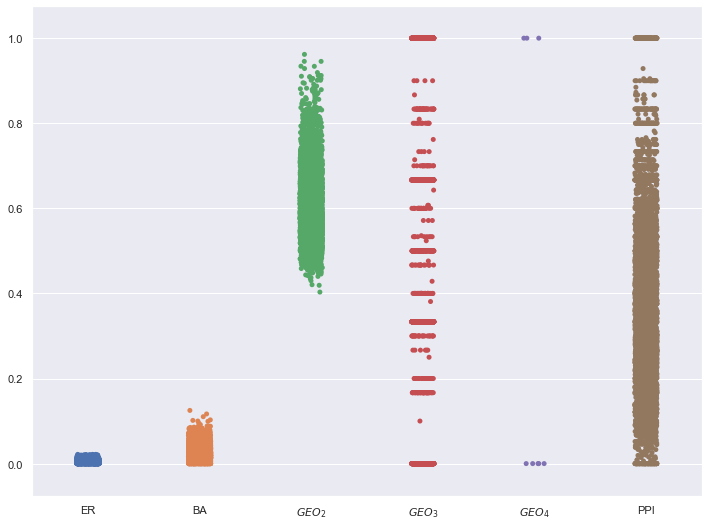

In [9]:
fig, ax = plt.subplots(figsize=(12,9))

#fig.patch.set_alpha(0)
#ax.patch.set_alpha(0)

buffer = 0.075
ax.set_ylim([-buffer,1+buffer])

sns.stripplot(data = df, ax=ax);

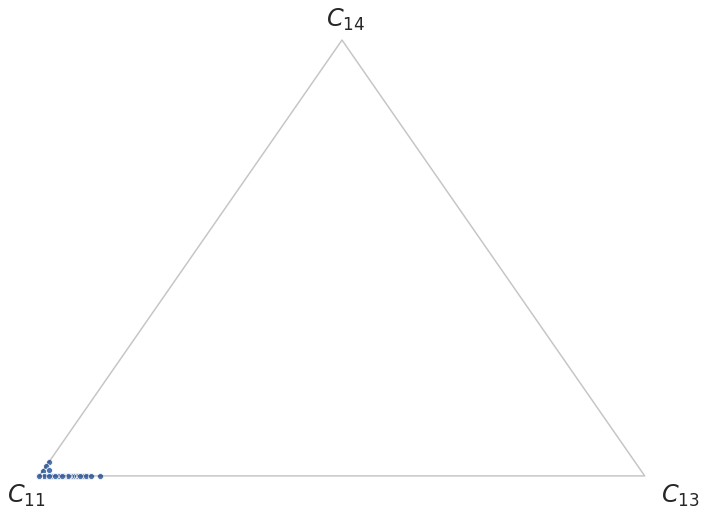

In [92]:
C3 = (GCV1['3']@T).dropna()

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_xlim([v1x-buffer,v2x+buffer])
ax.set_ylim([v1y-buffer,v3y+buffer])
ax.axis('off')

ax.annotate(r'$C_{11}$', (v1x-buffer  ,v1y-buffer  ), fontsize=24)
ax.annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
ax.annotate(r'$C_{14}$', (v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=ax);
ax.plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);

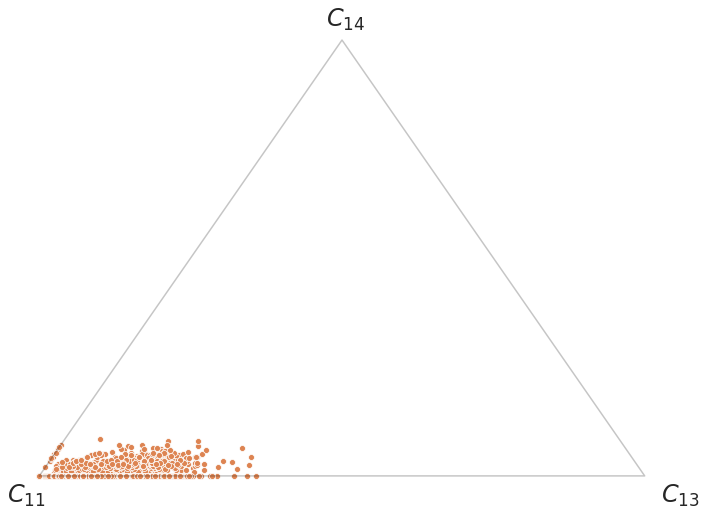

In [93]:
C3 = (GCV2['3']@T).dropna()

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_xlim([v1x-buffer,v2x+buffer])
ax.set_ylim([v1y-buffer,v3y+buffer])
ax.axis('off')

ax.annotate(r'$C_{11}$', (v1x-buffer  ,v1y-buffer  ), fontsize=24)
ax.annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
ax.annotate(r'$C_{14}$', (v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=ax, color=sns.color_palette()[1]);
ax.plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);

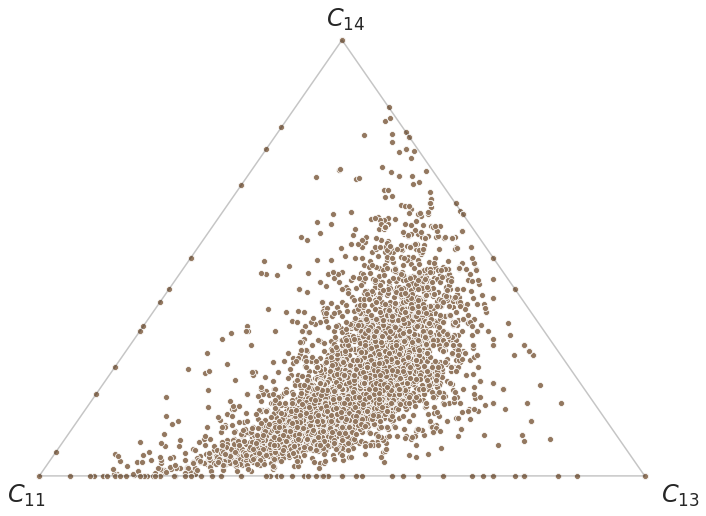

In [94]:
C3 = (GCV['3']@T).dropna()

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_xlim([v1x-buffer,v2x+buffer])
ax.set_ylim([v1y-buffer,v3y+buffer])
ax.axis('off')

ax.annotate(r'$C_{11}$', (v1x-buffer  ,v1y-buffer  ), fontsize=24)
ax.annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
ax.annotate(r'$C_{14}$', (v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=ax, color=sns.color_palette()[5]);
ax.plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);

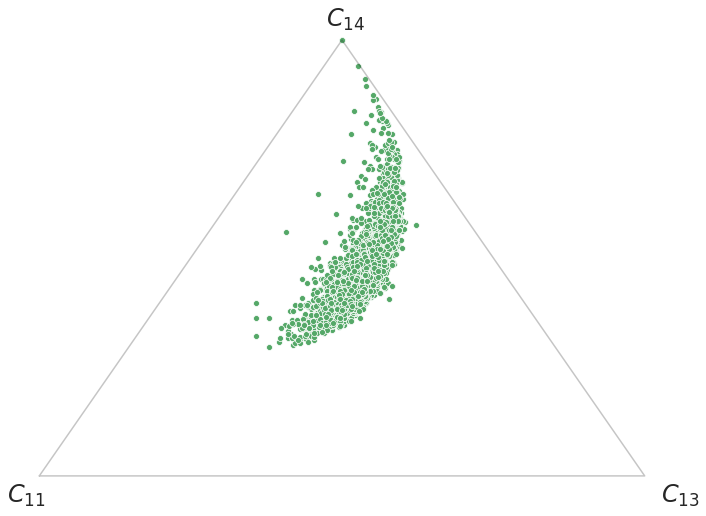

In [95]:
C3 = (GCV3['3']@T).dropna()

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_xlim([v1x-buffer,v2x+buffer])
ax.set_ylim([v1y-buffer,v3y+buffer])
ax.axis('off')

ax.annotate(r'$C_{11}$', (v1x-buffer  ,v1y-buffer  ), fontsize=24)
ax.annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
ax.annotate(r'$C_{14}$', (v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=ax, color=sns.color_palette()[2]);
ax.plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);

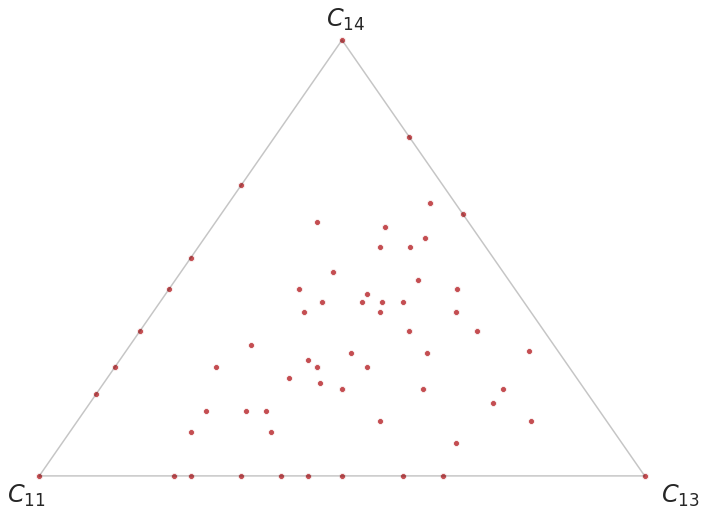

In [96]:
C3 = (GCV4['3']@T).dropna()

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_xlim([v1x-buffer,v2x+buffer])
ax.set_ylim([v1y-buffer,v3y+buffer])
ax.axis('off')

ax.annotate(r'$C_{11}$', (v1x-buffer  ,v1y-buffer  ), fontsize=24)
ax.annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
ax.annotate(r'$C_{14}$', (v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=ax, color=sns.color_palette()[3]);
ax.plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);

In [ ]:
C3 = (GCV1['3']@T).dropna()

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_xlim([v1x-buffer,v2x+buffer])
ax.set_ylim([v1y-buffer,v3y+buffer])
ax.axis('off')

ax.annotate(r'$C_{11}$', (v1x-buffer  ,v1y-buffer  ), fontsize=24)
ax.annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
ax.annotate(r'$C_{14}$', (v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=ax);
ax.plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);

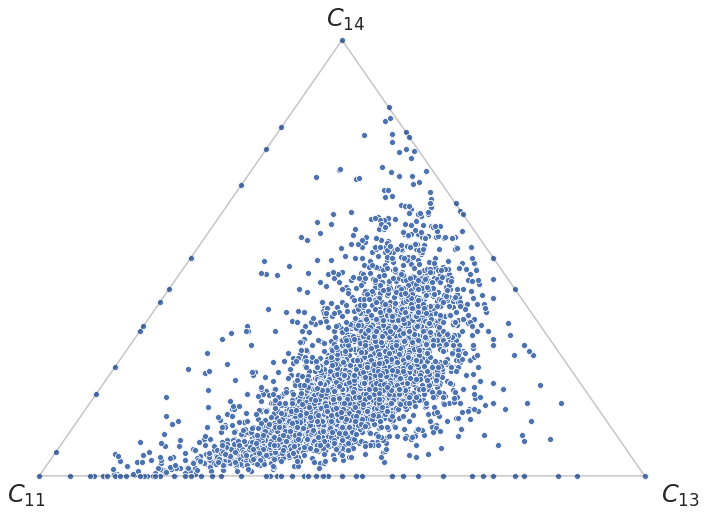

In [74]:
#Cluster coverage

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_xlim([v1x-buffer,v2x+buffer])
ax.set_ylim([v1y-buffer,v3y+buffer])
ax.axis('off')

ax.annotate(r'$C_{11}$', (v1x-buffer  ,v1y-buffer  ), fontsize=24)
ax.annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
ax.annotate(r'$C_{14}$', (v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=ax);
ax.plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);

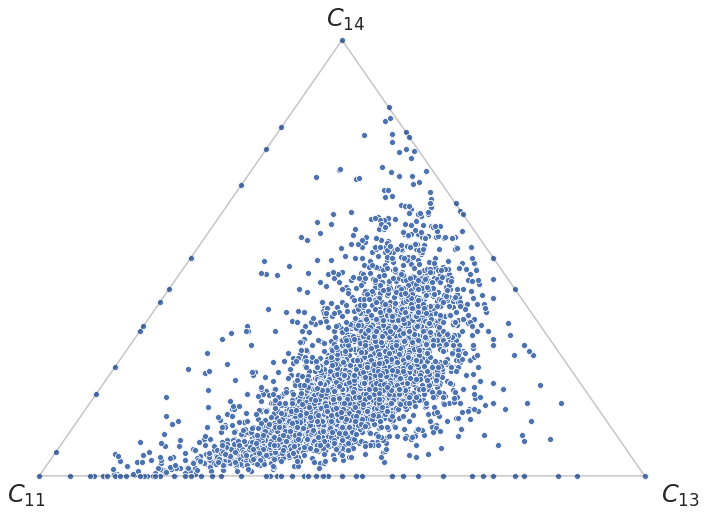

In [68]:
#Cluster coverage

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_xlim([v1x-buffer,v2x+buffer])
ax.set_ylim([v1y-buffer,v3y+buffer])
ax.axis('off')

ax.annotate(r'$C_{11}$', (v1x-buffer  ,v1y-buffer  ), fontsize=24)
ax.annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
ax.annotate(r'$C_{14}$', (v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=ax);
ax.plot([0,np.sqrt(2)/2, np.sqrt(2), 0], [0,np.sqrt(3/2), 0, 0], 'k', alpha=0.25);

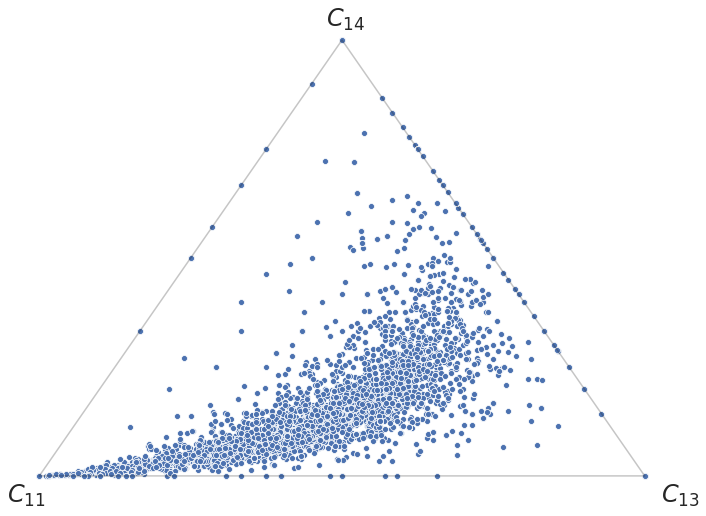

In [208]:
#Cluster coverage

C2 = (GCV['2']@T).dropna()

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_xlim([v1x-buffer,v2x+buffer])
ax.set_ylim([v1y-buffer,v3y+buffer])
ax.axis('off')

ax.annotate(r'$C_{11}$', (v1x-buffer  ,v1y-buffer  ), fontsize=24)
ax.annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
ax.annotate(r'$C_{14}$', (v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C2, x=0, y=1, ax=ax);
ax.plot([0,np.sqrt(2)/2, np.sqrt(2), 0], [0,np.sqrt(3/2), 0, 0], 'k', alpha=0.25);

In [135]:
(N-m)*m = E

561

In [106]:
x = np.random.uniform(size=[5,3])
x = x/np.sum(x)
graco.functions.tvd(x, [1/3,1/3,1/3])

1.9999999999999998

In [43]:
Pt = [0.1, 0.5, 0.4]
Pt_ = Pt@T
lb = 0.25
ub = lb+0.01
Pts = pd.DataFrame([x/sum(x) for x in np.random.uniform(size=[2**15,3]) 
                        if lb < hellinger1(x/sum(x), Pt) < ub])@T

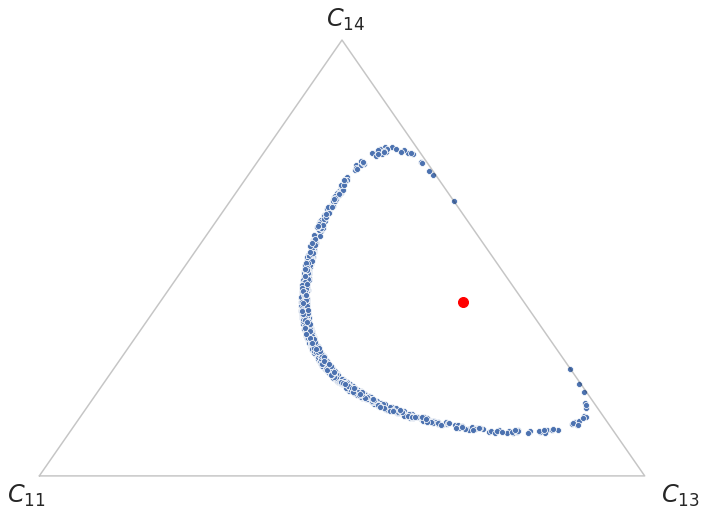

In [44]:
#Cluster coverage

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_xlim([v1x-buffer,v2x+buffer])
ax.set_ylim([v1y-buffer,v3y+buffer])
ax.axis('off')

ax.annotate(r'$C_{11}$', (v1x-buffer  ,v1y-buffer  ), fontsize=24)
ax.annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
ax.annotate(r'$C_{14}$', (v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = Pts, x=0, y=1, ax=ax);
ax.plot(*(Pt@T), 'o', markersize=10, color='red')
ax.plot([0,np.sqrt(2)/2, np.sqrt(2), 0], [0,np.sqrt(3/2), 0, 0], 'k', alpha=0.25);

In [163]:
Pt@T

array([0.70710678, 0.40824829])

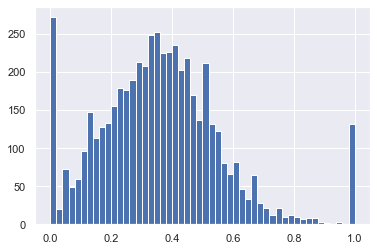

In [202]:
plt.hist(GCV['3']['11'].dropna(), bins=50);

In [206]:
sum(GCV['3']['14'] == 0)

470

In [ ]:
D = np.genfromtxt('/Users/markusyoussef/Desktop/git/supplements/data/matrix/sc_BioGRID_tvd0.txt')

In [ ]:
sqD = squareform(D)

In [ ]:
plt.hist(sqD, bins=50)

In [13]:
import numpy as np
from scipy.linalg import norm
from scipy.spatial.distance import euclidean

_SQRT2 = np.sqrt(2)     # sqrt(2) with default precision np.float64

def hellinger1(p, q):
    return norm(np.sqrt(p) - np.sqrt(q)) / _SQRT2


def hellinger2(p, q):
    return euclidean(np.sqrt(p), np.sqrt(q)) / _SQRT2


def hellinger3(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

In [14]:
hellinger1([1/6,2/6,3/6], [4,5,6])

1.0464614912706225